In [159]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from googletrans import Translator
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directoryt.

In [95]:
shops_df = pd.read_csv('shops.csv')
shops_df.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [96]:
item_cat_df = pd.read_csv('item_categories.csv')
item_cat_df.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [97]:
sales_train_df = pd.read_csv('sales_train.csv.gz')
sales_train_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [98]:
items_df = pd.read_csv('items.csv')
items_df.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [99]:
sales_test_df = pd.read_csv('test.csv.gz')
sales_test_df.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [100]:
# Creating a combined train df
df = pd.merge(sales_train_df, items_df, on='item_id')
# del df['item_name']
df['date'] = pd.to_datetime(sales_train_df['date'], format='%d.%m.%Y')
df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id
0,2013-01-02,0,59,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37
1,2013-01-03,0,24,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37
2,2013-01-05,0,27,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37
3,2013-01-06,0,25,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37
4,2013-01-15,0,25,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37


## Shops vs Shops clustering

In [101]:
# cluster shops based median value of items per shop sold for month, median value of items returned per shop for month, 
# median revenue monthly based
# use density based clustering//

# drop duplicates columns from original dataframe (combined df)//
df.drop_duplicates(inplace=True)

# compute revenue column using the original df//
df['Revenue'] = df['item_price']*df['item_cnt_day']

# bought items- positive values, negative values- returned=> so net total of items sold = bought items - returned items.
# compute net of items sold (bought-returned) per shop per month, Number of items returned per shop per month, 
# compute Net Revenue per shop per month, Number of items sold per shop per month
df_monthwise = df.groupby(['shop_id', 'date_block_num'])['item_cnt_day'].sum()
df_monthwise_returned = df[df['item_cnt_day'] < 0].groupby(['shop_id', 'date_block_num'])['item_cnt_day'].sum()
df_monthwise_rev = df.groupby(['shop_id', 'date_block_num'])['Revenue'].sum()
df_month_count = df.groupby(['shop_id', 'date_block_num'])['item_id'].count()

# create a shop df to cluster the shops based on attributes derived from all transactions provided in the dataset//
df_shop = pd.DataFrame()
df_shop['shop_id'] = df_monthwise.index.get_level_values(0)
df_shop['month'] = df_monthwise.index.get_level_values(1)
df_shop['Total_items_sold_permonth'] = df_monthwise.values
df_shop['No_of_transactions_permonth'] = df_month_count.values
df_shop['Revenue_per_month'] = df_monthwise_rev.values

# number of shops having less than 5 months of sales data- means either they are closed shops or newly opened shops.
df_shop_nummonths = df_shop.groupby(['shop_id'])['month'].count()
df_Filtered = df_shop_nummonths[df_shop_nummonths.values < 5]
list_shops_lessthan5 = df_Filtered.index.values

# removing those shops from the dataframe// (having less then 5 months sales data)
print('List of shop ids that have less than 5  months of sales data: ', list_shops_lessthan5)
df_shop_new = df_shop[~df_shop['shop_id'].isin(list_shops_lessthan5)]
df_shop_new.reset_index(drop=True, inplace=True)

# create a new dataframe to compute the number of items returned 
# (all negative values in dataset in price and cnt columns means the items where returned on that day)
# however returned items might have been bought at some point, this has been taken of by the net items sold attribute.
df_returned = df_monthwise_returned[df_monthwise_returned.index.get_level_values(0).isin(df_shop_new['shop_id'])]
returned_df = pd.DataFrame()
returned_df['shop_id'] = df_returned.index.get_level_values(0)
returned_df['date_block_num'] = df_returned.index.get_level_values(1)
returned_df['returned'] = df_returned.values

# now find high,median,low values for all the attributre columns found.
# this will be the final dataset used for shops clustering//
shop_df = pd.DataFrame()
shop_list = df_shop_new['shop_id']
df_monthwise_totalsold = df_shop_new.groupby(['shop_id'])['Total_items_sold_permonth'].median()
df_monthwise_totalsold_h = df_shop_new.groupby(['shop_id'])['Total_items_sold_permonth'].max()
df_monthwise_totalsold_l = df_shop_new.groupby(['shop_id'])['Total_items_sold_permonth'].min()
df_monthwise_transac = df_shop_new.groupby(['shop_id'])['No_of_transactions_permonth'].median()
df_monthwise_transac_h = df_shop_new.groupby(['shop_id'])['No_of_transactions_permonth'].max()
df_monthwise_transac_l = df_shop_new.groupby(['shop_id'])['No_of_transactions_permonth'].min()
df_monthwise_revenue = df_shop_new.groupby(['shop_id'])['Revenue_per_month'].median()
df_monthwise_revenue_h = df_shop_new.groupby(['shop_id'])['Revenue_per_month'].max()
df_monthwise_revenue_l = df_shop_new.groupby(['shop_id'])['Revenue_per_month'].min()
returned_shop_list = returned_df['shop_id']

# To account for shops that didn't have any items being returned per month, that is no negative values.
missing_shops = shop_list[~shop_list.isin(returned_shop_list)].unique()
shopid = []
month = []
returned = []

for i in missing_shops:
    shopid.append(i)
    month.append(0)
    returned.append(0)
    
missing_shop_df = pd.DataFrame()
missing_shop_df['shop_id'] = shopid
missing_shop_df['date_block_num'] = month
missing_shop_df['returned'] = returned
returned_df = returned_df.append(missing_shop_df)

# for shops that did not have any items returned- assign 0 as the value. Append it to the original list.
df_monthwise_returned  = returned_df.groupby('shop_id')['returned'].median()
df_monthwise_returned_h  = returned_df.groupby('shop_id')['returned'].max()
df_monthwise_returned_l  = returned_df.groupby('shop_id')['returned'].min()

shop_df['shop_id'] = df_monthwise_totalsold.index.values
shop_df['median_total_items_sold_permonth'] = df_monthwise_totalsold.values
shop_df['highest_total_items_sold_permonth'] = df_monthwise_totalsold_h.values
shop_df['lowest_total_items_sold_permonth'] = df_monthwise_totalsold_l.values
shop_df['median_no_of_transactions_permonth'] = df_monthwise_transac.values
shop_df['highest_no_of_transactions_permonth'] = df_monthwise_transac_h.values
shop_df['lowest_no_of_transactions_permonth'] = df_monthwise_transac_l.values
shop_df['median_revenue_per_month'] = df_monthwise_revenue.values
shop_df['highest_revenue_per_month'] = df_monthwise_revenue_h.values
shop_df['lowest_revenue_per_month'] = df_monthwise_revenue_l.values
shop_df['median_total_returned_items_permonth'] = df_monthwise_returned.values
shop_df['highest_total_returned_items_permonth'] = df_monthwise_returned_h.values
shop_df['lowest_total_returned_items_permonth'] = df_monthwise_returned_l.values

print('\nFinal dataframe for shops: \n')
shop_df.to_csv('shops_df.csv',header=True)
shop_df

List of shop ids that have less than 5  months of sales data:  [ 0  1  8  9 11 20 23 36]

Final dataframe for shops: 



,shop_id,median_total_items_sold_permonth,highest_total_items_sold_permonth,lowest_total_items_sold_permonth,median_no_of_transactions_permonth,highest_no_of_transactions_permonth,lowest_no_of_transactions_permonth,median_revenue_per_month,highest_revenue_per_month,lowest_revenue_per_month,median_total_returned_items_permonth,highest_total_returned_items_permonth,lowest_total_returned_items_permonth
0,2,857.0,1867.0,485.0,718.5,1473,451,1099012.750,3.178114e+06,519712.00,-3.0,-1.0,-9.0
1,3,771.0,1244.0,525.0,708.5,1128,507,823883.000,1.894671e+06,396785.00,-4.0,-1.0,-9.0
2,4,1205.5,2187.0,283.0,1060.0,1846,254,1137169.400,2.457445e+06,200458.00,-3.0,-1.0,-11.0
3,5,1241.0,2176.0,867.0,1110.0,1804,792,1076897.000,2.598236e+06,519175.00,-2.0,-1.0,-9.0
4,6,2966.0,5311.0,1465.0,2307.5,4370,1281,2511357.750,5.850954e+06,1579537.00,-7.0,-1.0,-22.0
5,7,1898.0,3608.0,1186.0,1660.0,2878,1007,1685485.485,4.498091e+06,981741.50,-3.0,-1.0,-11.0
6,10,725.0,1292.0,423.0,606.0,1133,362,490586.600,1.221859e+06,327637.25,0.0,0.0,0.0
7,12,1845.5,5194.0,717.0,970.0,2148,620,2354656.800,9.693545e+06,849342.95,-10.0,-1.0,-51.0
8,13,1007.5,1329.0,209.0,901.0,1203,199,289971.500,5.817430e+05,75001.00,0.0,0.0,0.0
9,14,1221.5,2176.0,795.0,980.5,1629,489,1261189.500,2.489288e+06,730864.00,-3.5,-1.0,-21.0


In [102]:
# since different variable are in different scales (the variance will be different), 
# scaling the features before clustering them provides improved clustering results and to reduce dimensionality issues.
# we havent removed outliers as DBSCAN can account for it and aslo outliers as shown below arent many (plot taken
# from previous assignment- EDA) 
scaler = MinMaxScaler(feature_range=(0, 10))
scaler.fit(shop_df)
# Final scaled dataframe to be feed to the DBSCAN clustering
scaled_shop_df = scaler.transform(shop_df)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.



## DBSCAN trial-1

In [103]:
clustering = DBSCAN(eps=2, min_samples=2, metric='euclidean', n_jobs=5).fit(scaled_shop_df)
shop_df['cluster_labels'] = clustering.labels_
print(clustering)


DBSCAN(algorithm='auto', eps=2, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=2, n_jobs=5, p=None)


In [104]:
shop_df['cluster_labels'].unique()

array([ 0, -1,  1,  2,  3,  4,  5,  6,  7,  8])

In [105]:
print(clustering.core_sample_indices_)

[ 0  1  2  3  5  6  8 10 11 12 13 15 16 17 19 22 26 27 28 29 30 31 32 35
 36 37 38 39 40 42 44 45]


In [106]:
# Number of points per cluster
print(len(shop_df[shop_df['cluster_labels']==3]))
print(len(shop_df[shop_df['cluster_labels']==2]))
print(len(shop_df[shop_df['cluster_labels']==1]))
print(len(shop_df[shop_df['cluster_labels']==0]))
print(len(shop_df[shop_df['cluster_labels']==4]))
print(len(shop_df[shop_df['cluster_labels']==5]))
print(len(shop_df[shop_df['cluster_labels']==6]))
print(len(shop_df[shop_df['cluster_labels']==7]))
print(len(shop_df[shop_df['cluster_labels']==-1]))
print(len(shop_df[shop_df['cluster_labels']==8]))

2
2
10
4
4
4
2
2
20
2


## DBSCAN

In [107]:
clustering = DBSCAN(eps=3, min_samples=3, metric='euclidean', n_jobs=5).fit(scaled_shop_df)
shop_df['cluster_labels'] = clustering.labels_
colour = []
for i in clustering.labels_:
    if i == 0:
        colour.append('blue')
    elif i == 1:
        colour.append('green')
    elif i == 2:
        colour.append('orange')
    elif i == 3:
        colour.append('black')
    elif i == -1:
        colour.append('red')
shop_df['colour'] = colour
print(clustering)


DBSCAN(algorithm='auto', eps=3, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=3, n_jobs=5, p=None)


In [108]:
shop_df['cluster_labels'].unique()

array([ 0, -1])

In [109]:
print(clustering.core_sample_indices_)

[ 0  1  2  3  5  9 10 11 12 13 15 16 17 19 22 26 27 28 29 30 31 32 33 36
 37 38 39 40 41 42 44 45 48 51]


In [110]:
# Number of points per cluster
print(len(shop_df[shop_df['cluster_labels']==3]))
print(len(shop_df[shop_df['cluster_labels']==2]))
print(len(shop_df[shop_df['cluster_labels']==1]))
print(len(shop_df[shop_df['cluster_labels']==0]))
print(len(shop_df[shop_df['cluster_labels']==-1]))

0
0
0
38
14


In [111]:
# points in each cluster//
# Number of points per cluster
print(shop_df[shop_df['cluster_labels']==3]['shop_id'])
print("\n", shop_df[shop_df['cluster_labels']==2]['shop_id'])
print("\n",shop_df[shop_df['cluster_labels']==1]['shop_id'])
print("\n",shop_df[shop_df['cluster_labels']==0]['shop_id'])
print("\n",shop_df[shop_df['cluster_labels']==-1]['shop_id'])

Series([], Name: shop_id, dtype: int64)

 Series([], Name: shop_id, dtype: int64)

 Series([], Name: shop_id, dtype: int64)

 0      2
1      3
2      4
3      5
5      7
9     14
10    15
11    16
12    17
13    18
15    21
16    22
17    24
19    26
22    29
23    30
25    32
26    33
27    34
28    35
29    37
30    38
31    39
32    40
33    41
35    43
36    44
37    45
38    46
39    47
40    48
41    49
42    50
44    52
45    53
48    56
50    58
51    59
Name: shop_id, dtype: int64

 4      6
6     10
7     12
8     13
14    19
18    25
20    27
21    28
24    31
34    42
43    51
46    54
47    55
49    57
Name: shop_id, dtype: int64


In [112]:
# scatter plot using one few features indepently to depict the clustering results//
# Plot data//
data = [go.Scatter(
    y = shop_df['median_total_items_sold_permonth'],
    x= shop_df['shop_id'],
    name = 'median Net items sold',
    text = 'Median net items sold',
    mode = 'markers',
    marker = dict(
        size = 10,
        color = shop_df['colour'],
        line = dict(
            width = 1.5,
            color = 'yellow'
        )
    ),
    opacity = 0.7
)]

# Create/Design layout for the plot
layout = dict(title = 'Average(median) Net items sold per month per shop',
              yaxis = dict(title='Median net items sold per shop',
                        showgrid=False,
                    ),
              xaxis = dict(title='Shop ID',
                        showgrid=False,
                    ),
              showlegend=True,
              legend=dict(bgcolor='lightgray',
                        bordercolor='gray',
                        borderwidth=2
                    )
             )

# Combine data and layout into a single figure
fig = dict(data=data, layout=layout)

# IPython notebook- plot
iplot(fig, filename='scatter-sentimentscore')

In [113]:
# scatter plot using one few features indepently to depict the clustering results//
# Plot data//
data = [go.Scatter(
    y = shop_df['highest_total_items_sold_permonth'],
    x = shop_df['shop_id'],
    name = 'Highest Net items sold',
    text = 'Max net items sold',
    mode = 'markers',
    marker = dict(
        size = 10,
        color = shop_df['colour'],
        line = dict(
            width = 1.5,
            color = 'yellow',
        )
    ),
    opacity = 0.7
)]

# Create/Design layout for the plot
layout = dict(title = 'Highest Net items sold per month per shop',
              yaxis = dict(title='Max net items sold per shop',
                        showgrid=False,
                    ),
              xaxis = dict(title='Shop ID',
                        showgrid=False,
                    ),
              showlegend=True,
              legend=dict(bgcolor='lightgray',
                        bordercolor='gray',
                        borderwidth=2
                    )
             )

# Combine data and layout into a single figure
fig = dict(data=data, layout=layout)

# IPython notebook- plot
iplot(fig, filename='scatter-sentimentscore')

In [114]:
# scatter plot using one few features indepently to depict the clustering results//
# Plot data//
data = [go.Scatter(
    y = shop_df['lowest_total_items_sold_permonth'],
    x = shop_df['shop_id'],
    name = 'Lowest Net items sold',
    text = 'Min net items sold',
    mode = 'markers',
    marker = dict(
        size = 10,
        color = shop_df['colour'],
        line = dict(
            width = 1.5,
            color = 'yellow',
        )
    ),
    opacity = 0.7
)]

# Create/Design layout for the plot
layout = dict(title = 'Lowest Net items sold per month per shop',
              yaxis = dict(title='Min net items sold per shop',
                        showgrid=False,
                    ),
              xaxis = dict(title='Shop ID',
                        showgrid=False,
                    ),
              showlegend=True,
              legend=dict(bgcolor='lightgray',
                        bordercolor='gray',
                        borderwidth=2
                    )
             )

# Combine data and layout into a single figure
fig = dict(data=data, layout=layout)

# IPython notebook- plot
iplot(fig, filename='scatter-sentimentscore')

In [115]:
# scatter plot using one few features indepently to depict the clustering results//
# Plot data//
data = [go.Scatter(
    y = shop_df['median_revenue_per_month'],
    x = shop_df['shop_id'],
    name = 'Median Revenue per month',
    text = 'Median revenue per month',
    mode = 'markers',
    marker = dict(
        size = 10,
        color = shop_df['colour'],
        line = dict(
            width = 1.5,
            color = 'green'
        )
    ),
    opacity = 0.7
)]

# Create/Design layout for the plot
layout = dict(title = 'Median revenue per month per shop',
              yaxis = dict(title='Median revenue per shop',
                        showgrid=False,
                    ),
              xaxis = dict(title='Shop ID',
                        showgrid=False,
                    ),
              showlegend=True,
              legend=dict(bgcolor='lightgray',
                        bordercolor='gray',
                        borderwidth=2
                    )
             )

# Combine data and layout into a single figure
fig = dict(data=data, layout=layout)

# IPython notebook- plot
iplot(fig, filename='scatter-sentimentscore')

In [116]:
# scatter plot using one few features indepently to depict the clustering results//
# Plot data//
data = [go.Scatter(
    y = shop_df['highest_revenue_per_month'],
    x = shop_df['shop_id'],
    name = 'Highest Revenue per month',
    text = 'Max revenue per month',
    mode = 'markers',
    marker = dict(
        size = 10,
        color = shop_df['colour'],
        line = dict(
            width = 1.5,
            color = 'green'
        )
    ),
    opacity = 0.7
)]

# Create/Design layout for the plot
layout = dict(title = 'Highest revenue per month per shop',
              yaxis = dict(title='Max revenue per shop',
                        showgrid=False,
                    ),
              xaxis = dict(title='Shop ID',
                        showgrid=False,
                    ),
              showlegend=True,
              legend=dict(bgcolor='lightgray',
                        bordercolor='gray',
                        borderwidth=2
                    )
             )

# Combine data and layout into a single figure
fig = dict(data=data, layout=layout)

# IPython notebook- plot
iplot(fig, filename='scatter-sentimentscore')

In [117]:
# scatter plot using one few features indepently to depict the clustering results//
# Plot data//
data = [go.Scatter(
    y = shop_df['lowest_revenue_per_month'],
    x = shop_df['shop_id'],
    name = 'Lowest Revenue per month',
    text = 'Min revenue per month',
    mode = 'markers',
    marker = dict(
        size = 10,
        color = shop_df['colour'],
        line = dict(
            width = 1.5,
            color = 'yellow'
        )
    ),
    opacity = 0.7
)]

# Create/Design layout for the plot
layout = dict(title = 'Lowest revenue per month per shop',
              yaxis = dict(title='Min revenue per shop',
                        showgrid=False,
                    ),
              xaxis = dict(title='Shop ID',
                        showgrid=False,
                    ),
              showlegend=True,
              legend=dict(bgcolor='lightgray',
                        bordercolor='gray',
                        borderwidth=2
                    )
             )

# Combine data and layout into a single figure
fig = dict(data=data, layout=layout)

# IPython notebook- plot
iplot(fig, filename='scatter-sentimentscore')

In [118]:
# scatter plot using one few features indepently to depict the clustering results//
# Plot data//
data = [go.Scatter(
    y = shop_df['median_total_returned_items_permonth'],
    x = shop_df['shop_id'],
    name = 'Median Total returned items per month',
    text = 'Median net returned items',
    mode = 'markers',
    marker = dict(
        size = 10,
        color = shop_df['colour'],
        line = dict(
            width = 1.5,
            color = 'blue'
        )
    ),
    opacity = 0.7
)]

# Create/Design layout for the plot
layout = dict(title = 'Median Total returned items per month per shop',
              yaxis = dict(title='Median net returned items',
                        showgrid=False,
                    ),
              xaxis = dict(title='Shop ID',
                        showgrid=False,
                    ),
              showlegend=True,
              legend=dict(bgcolor='lightgray',
                        bordercolor='gray',
                        borderwidth=2
                    )
             )

# Combine data and layout into a single figure
fig = dict(data=data, layout=layout)

# IPython notebook- plot
iplot(fig, filename='scatter-sentimentscore')

In [119]:
# scatter plot using one few features indepently to depict the clustering results//
# Plot data//
data = [go.Scatter(
    y = shop_df['highest_total_returned_items_permonth'],
    x = shop_df['shop_id'],
    name = 'Highest Total returned items per month',
    text = 'Highest net returned items',
    mode = 'markers',
    marker = dict(
        size = 10,
        color = shop_df['colour'],
        line = dict(
            width = 1.5,
            color = 'blue'
        )
    ),
    opacity = 0.7
)]

# Create/Design layout for the plot
layout = dict(title = 'Highest Total returned items per month per shop',
              yaxis = dict(title='Highest net returned items',
                        showgrid=False,
                    ),
              xaxis = dict(title='Shop ID',
                        showgrid=False,
                    ),
              showlegend=True,
              legend=dict(bgcolor='lightgray',
                        bordercolor='gray',
                        borderwidth=2
                    )
             )

# Combine data and layout into a single figure
fig = dict(data=data, layout=layout)

# IPython notebook- plot
iplot(fig, filename='scatter-sentimentscore')

In [120]:
# scatter plot using one few features indepently to depict the clustering results//
# Plot data//
data = [go.Scatter(
    y = shop_df['lowest_total_returned_items_permonth'],
    x = shop_df['shop_id'],
    name = 'Lowest Total returned items per month',
    text = 'Lowest net returned items',
    mode = 'markers',
    marker = dict(
        size = 10,
        color = shop_df['colour'],
        line = dict(
            width = 1.5,
            color = 'blue'
        )
    ),
    opacity = 0.7
)]

# Create/Design layout for the plot
layout = dict(title = 'Lowest Total returned items per month per shop',
              yaxis = dict(title='Lowest net returned items',
                        showgrid=False,
                    ),
              xaxis = dict(title='Shop ID',
                        showgrid=False,
                    ),
              showlegend=True,
              legend=dict(bgcolor='lightgray',
                        bordercolor='gray',
                        borderwidth=2
                    )
             )

# Combine data and layout into a single figure
fig = dict(data=data, layout=layout)

# IPython notebook- plot
iplot(fig, filename='scatter-sentimentscore')

In [121]:
# scatter plot using one few features indepently to depict the clustering results//
# Plot data//
data = [go.Scatter(
    y = shop_df['median_no_of_transactions_permonth'],
    x = shop_df['shop_id'],
    name = 'Median Total transactions per month',
    text = 'Median Total transactions',
    mode = 'markers',
    marker = dict(
        size = 10,
        color = shop_df['colour'],
        line = dict(
            width = 1.5,
            color = 'yellow'
        )
    ),
    opacity = 0.7
)]

# Create/Design layout for the plot
layout = dict(title = 'Median Total transactions per month per shop',
              yaxis = dict(title='Median Total transactions',
                        showgrid=False,
                    ),
              xaxis = dict(title='Shop ID',
                        showgrid=False,
                    ),
              showlegend=True,
              legend=dict(bgcolor='lightgray',
                        bordercolor='gray',
                        borderwidth=2
                    )
             )

# Combine data and layout into a single figure
fig = dict(data=data, layout=layout)

# IPython notebook- plot
iplot(fig, filename='scatter-sentimentscore')

In [122]:
# scatter plot using one few features indepently to depict the clustering results//
# Plot data//
data = [go.Scatter(
    y = shop_df['highest_no_of_transactions_permonth'],
    x = shop_df['shop_id'],
    name = 'Highest Total transactions per month',
    text = 'Highest Total transactions',
    mode = 'markers',
    marker = dict(
        size = 10,
        color = shop_df['colour'],
        line = dict(
            width = 1.5,
            color = 'yellow'
        )
    ),
    opacity = 0.7
)]

# Create/Design layout for the plot
layout = dict(title = 'Highest Total transactions per month per shop',
              yaxis = dict(title='Highest Total transactions',
                        showgrid=False,
                    ),
              xaxis = dict(title='Shop ID',
                        showgrid=False,
                    ),
              showlegend=True,
              legend=dict(bgcolor='lightgray',
                        bordercolor='gray',
                        borderwidth=2
                    )
             )

# Combine data and layout into a single figure
fig = dict(data=data, layout=layout)

# IPython notebook- plot
iplot(fig, filename='scatter-sentimentscore')

In [123]:
# scatter plot using one few features indepently to depict the clustering results//
# Plot data//
data = [go.Scatter(
    y = shop_df['lowest_no_of_transactions_permonth'],
    x = shop_df['shop_id'],
    name = 'Lowest Total transactions per month',
    text = 'Lowest Total transactions',
    mode = 'markers',
    marker = dict(
        size = 10,
        color = shop_df['colour'],
        line = dict(
            width = 1.5,
            color = 'yellow'
        )
    ),
    opacity = 0.7
)]

# Create/Design layout for the plot
layout = dict(title = 'Lowest Total transactions per month per shop',
              yaxis = dict(title='Lowest Total transactions',
                        showgrid=False,
                    ),
              xaxis = dict(title='Shop ID',
                        showgrid=False,
                    ),
              showlegend=True,
              legend=dict(bgcolor='lightgray',
                        bordercolor='gray',
                        borderwidth=2
                    )
             )

# Combine data and layout into a single figure
fig = dict(data=data, layout=layout)

# IPython notebook- plot
iplot(fig, filename='scatter-sentimentscore')

In [125]:
from googletrans import Translator
translator = Translator()

def translate_to_english(x):
    return translator.translate(x, src='ru').text

item_cat_df['english_item_cat_name'] = item_cat_df.item_category_name.apply(lambda x: translate_to_english(x))

def higher_category(x):
    if '-' in x:
        return x.split('-')[0]
    else:
        return x

item_cat_df['higher_category'] = item_cat_df.english_item_cat_name.apply(lambda x: higher_category(x))

item_cat_df.head()

## Item_categories

In [181]:
# cluster items based on number of items in a item category, number of items being sold per item category per month, 
# median price of the item sales per category per month, number of times that was what returned per category per month
# use hierachial clustering// also, we use median, lowest and highest values in each of the above defined attributes.
# we consider median, lowest and highest cause we don't want the clustering algorithm to lack accuracy due to skewed- datasets.
# considering max and min values, naturally helps the algorithm understand the range and scale features.

# bought items- positive values, negative values- returned=> so net total of items sold = bought items - returned items.
# compute net of items sold (bought-returned) per item_cat per month, Number of items returned per item_cat per month, 
# compute Net Revenue per item_cat per month, Number of items sold per item_cat per month
df_monthwise = df.groupby(['item_category_id', 'date_block_num'])['item_cnt_day'].sum()
df_monthwise_returned = df[df['item_cnt_day'] < 0].groupby(['item_category_id', 'date_block_num'])['item_cnt_day'].sum()
df_monthwise_sales = df.groupby(['item_category_id', 'date_block_num'])['Revenue'].sum()
df_num_itemspercat = df.groupby(['item_category_id', 'date_block_num'])['item_id'].count()

# create a items_cat df to cluster the item_cat based on attributes derived from all transactions provided in the dataset//
df_shop = pd.DataFrame()
df_shop['item_category_id'] = df_monthwise.index.get_level_values(0) 
df_shop['month'] = df_monthwise.index.get_level_values(1)
df_shop['Total_items_sold_peritemcat'] = df_monthwise.values # number of items sold per item category per month
df_shop['No_of_items_percat'] = df_num_itemspercat.values # number of items per item category per month
df_shop['sales_per_itemcat'] = df_monthwise_sales.values # money/sales value of items sold per item category per month

df_shop.head()

# create a new dataframe to compute the number of items returned 
# (all negative values in dataset in price and cnt columns means the items where returned on that day)
# however returned items might have been bought at some point, this has been taken of by the net items sold attribute.
df_returned = df_monthwise_returned[df_monthwise_returned.index.get_level_values(0).isin(df_shop['item_category_id'])]
returned_df = pd.DataFrame()
returned_df['item_category_id'] = df_returned.index.get_level_values(0)
returned_df['date_block_num'] = df_returned.index.get_level_values(1)
returned_df['returned'] = df_returned.values

returned_df

# now find high,median,low values for all the attributre columns found.
# this will be the final dataset used for shops clustering//
items_cat_df = pd.DataFrame()
shop_list = df_shop['item_category_id']
df_monthwise_totalsold = df_shop.groupby(['item_category_id'])['Total_items_sold_peritemcat'].median()
df_monthwise_totalsold_h = df_shop.groupby(['item_category_id'])['Total_items_sold_peritemcat'].max()
df_monthwise_totalsold_l = df_shop.groupby(['item_category_id'])['Total_items_sold_peritemcat'].min()
df_monthwise_transac = df_shop.groupby(['item_category_id'])['No_of_items_percat'].median()
df_monthwise_transac_h = df_shop.groupby(['item_category_id'])['No_of_items_percat'].max()
df_monthwise_transac_l = df_shop.groupby(['item_category_id'])['No_of_items_percat'].min()
df_monthwise_revenue = df_shop.groupby(['item_category_id'])['sales_per_itemcat'].median()
df_monthwise_revenue_h = df_shop.groupby(['item_category_id'])['sales_per_itemcat'].max()
df_monthwise_revenue_l = df_shop.groupby(['item_category_id'])['sales_per_itemcat'].min()
returned_shop_list = returned_df['item_category_id']

# To account for item_categories that didn't have any items being returned per month, that is no negative values.
# read shops as item_categories
missing_shops = shop_list[~shop_list.isin(returned_shop_list)].unique()
shopid = []
month = []
returned = []

for i in missing_shops:
    shopid.append(i)
    month.append(0)
    returned.append(0)
    
missing_shop_df = pd.DataFrame()
missing_shop_df['item_category_id'] = shopid
missing_shop_df['date_block_num'] = month
missing_shop_df['returned'] = returned
returned_df = returned_df.append(missing_shop_df)

# for item_Categories that did not have any items returned- assign 0 as the value. Append it to the original list.
df_monthwise_returned  = returned_df.groupby('item_category_id')['returned'].median()
df_monthwise_returned_h  = returned_df.groupby('item_category_id')['returned'].max()
df_monthwise_returned_l  = returned_df.groupby('item_category_id')['returned'].min()

items_cat_df['item_category_id'] = df_monthwise_totalsold.index.values
items_cat_df['median_total_items_sold_peritemcat'] = df_monthwise_totalsold.values
items_cat_df['highest_total_items_sold_peritemcat'] = df_monthwise_totalsold_h.values
items_cat_df['lowest_total_items_sold_peritemcat'] = df_monthwise_totalsold_l.values
items_cat_df['median_no_of_items_peritemcat'] = df_monthwise_transac.values
items_cat_df['highest_no_of_items_peritemcat'] = df_monthwise_transac_h.values
items_cat_df['lowest_no_of_items_peritemcat'] = df_monthwise_transac_l.values
items_cat_df['median_sales_peritemcat'] = df_monthwise_revenue.values
items_cat_df['highest_sales_peritemcat'] = df_monthwise_revenue_h.values
items_cat_df['lowest_sales_per_month'] = df_monthwise_revenue_l.values
items_cat_df['median_total_returned_items_peritemcat'] = df_monthwise_returned.values

print('\nFinal dataframe for shops: \n')
items_cat_df.to_csv('items_cat.csv',header=True)
items_cat_df



Final dataframe for shops: 



,item_category_id,median_total_items_sold_peritemcat,highest_total_items_sold_peritemcat,lowest_total_items_sold_peritemcat,median_no_of_items_peritemcat,highest_no_of_items_peritemcat,lowest_no_of_items_peritemcat,median_sales_peritemcat,highest_sales_peritemcat,lowest_sales_per_month,median_total_returned_items_peritemcat
0,0,1.0,1.0,1.0,1.0,1,1,9.300000e+01,1.480000e+02,22.40,0.0
1,1,1.0,1.0,1.0,1.0,1,1,2.155000e+02,2.830000e+02,148.00,0.0
2,2,494.0,2126.0,81.0,480.0,1760,80,1.095333e+06,4.127846e+06,232133.75,-3.0
3,3,740.5,2855.0,136.0,710.5,1997,120,1.881207e+06,6.354303e+06,69141.20,-4.0
4,4,46.0,246.0,1.0,46.0,233,1,1.442300e+04,2.277310e+05,58.00,-1.0
5,5,197.5,631.0,31.0,194.0,586,32,1.455507e+05,6.129021e+05,19768.00,-1.0
6,6,605.5,1336.0,231.0,563.5,1047,220,1.043898e+06,2.641228e+06,573279.35,-3.0
7,7,243.5,1652.0,178.0,228.5,1089,132,6.720375e+05,4.520283e+06,383574.68,-2.0
8,8,170.0,5202.0,-1.0,69.0,943,1,1.916000e+05,7.346290e+06,-1500.00,-1.0
9,9,378.5,2524.0,83.0,58.0,112,35,1.611505e+05,4.818620e+05,60887.00,-4.0


In [182]:
# since different variable are in different scales (the variance will be different), 
# scaling the features before clustering them provides improved clustering results and to reduce dimensionality issues.

scaler = MinMaxScaler(feature_range=(0, 10))
scaler.fit(items_cat_df)
# Final scaled dataframe to be feed to the aggolomerative clustering
scaled_item_cat_df = scaler.transform(items_cat_df)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.



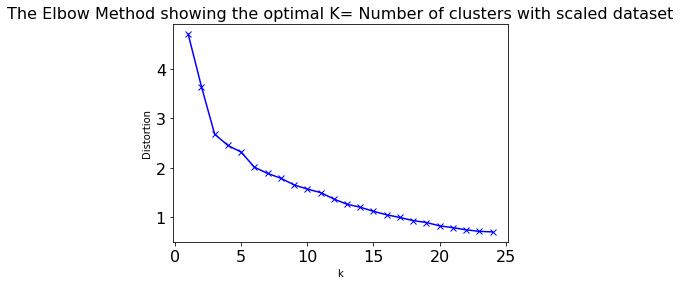

In [183]:
# K-means to determine good n_clusters (number of clusters to you think the dataset has) for agglomertaive hierachial clustering//
# use elbow method for with and without scaling datasets to determine good k for k-means..

# k means determine k
distortions = []
K = range(1,25)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(scaled_item_cat_df)
    kmeanModel.fit(scaled_item_cat_df)
    distortions.append(sum(np.min(cdist(scaled_item_cat_df, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / scaled_item_cat_df.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal K= Number of clusters with scaled dataset')
plt.show()

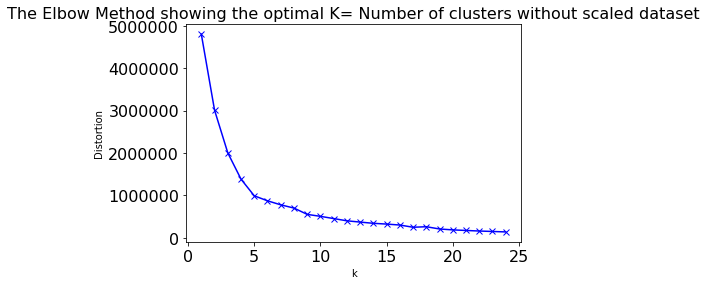

In [184]:
# same elbow method applied to original non-scaled dataset
# k means determine k
distortions = []
K = range(1,25)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(items_cat_df)
    kmeanModel.fit(items_cat_df)
    distortions.append(sum(np.min(cdist(items_cat_df, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / items_cat_df.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal K= Number of clusters without scaled dataset')
plt.show()

In [197]:
# based on the n_clusters determined, we take "5" (where we can see the elbow take a sharp cut) with scald dataset and perform bottom up clustering
clustering = AgglomerativeClustering(n_clusters=5).fit(scaled_item_cat_df)
print(clustering)
print(clustering.labels_)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=5,
            pooling_func='deprecated')
[2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 0 0 1 1 0 1 1 1 1 0 1 3 1 1 1 1 1 1
 0 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4]


In [198]:
items_cat_df['cluster_labels'] = clustering.labels_
colour = []
for i in clustering.labels_:
    if i == 0:
        colour.append('blue')
    elif i == 1:
        colour.append('green')
    elif i == 2:
        colour.append('orange')
    elif i == 3:
        colour.append('black')
    elif i == -1:
        colour.append('red')
    elif i == 4:
        colour.append('pink')
    elif i == 5:
        colour.append('brown')
    elif i == 6:
        colour.append('magenta')
        
items_cat_df['colour'] = colour

In [199]:
# Number of points per cluster
print(len(items_cat_df[items_cat_df['cluster_labels']==3]))
print(len(items_cat_df[items_cat_df['cluster_labels']==2]))
print(len(items_cat_df[items_cat_df['cluster_labels']==1]))
print(len(items_cat_df[items_cat_df['cluster_labels']==0]))
print(len(items_cat_df[items_cat_df['cluster_labels']==4]))

3
18
36
6
21


In [213]:
# scatter plot using one few features indepently to depict the clustering results//
# Plot data//
data = [go.Scatter(
    y = items_cat_df['median_total_items_sold_peritemcat'],
    x= items_cat_df['item_category_id'],
    name = 'median Net items sold',
    text = 'Median net items sold',
    mode = 'markers',
    marker = dict(
        size = 10,
        color = items_cat_df['colour'],
        line = dict(
            width = 1.5,
            color = 'yellow'
        )
    ),
    opacity = 0.7
)]

# Create/Design layout for the plot
layout = dict(title = 'Average(median) Net items sold per item category per month',
              yaxis = dict(title='Median net items sold',
                        showgrid=False,
                    ),
              xaxis = dict(title='Item Category ID',
                        showgrid=False,
                    ),
              showlegend=True,
              legend=dict(bgcolor='lightgray',
                        bordercolor='gray',
                        borderwidth=2
                    )
             )

# Combine data and layout into a single figure
fig = dict(data=data, layout=layout)

# IPython notebook- plot
iplot(fig, filename='scatter-sentimentscore')

In [214]:
# scatter plot using one few features indepently to depict the clustering results//
# Plot data//
data = [go.Scatter(
    y = items_cat_df['highest_total_items_sold_peritemcat'],
    x= items_cat_df['item_category_id'],
    name = 'Highest Net items sold',
    text = 'Highest net items sold',
    mode = 'markers',
    marker = dict(
        size = 10,
        color = items_cat_df['colour'],
        line = dict(
            width = 1.5,
            color = 'yellow'
        )
    ),
    opacity = 0.7
)]

# Create/Design layout for the plot
layout = dict(title = 'Highest Net items sold per item category per month',
              yaxis = dict(title='Highest net items sold',
                        showgrid=False,
                    ),
              xaxis = dict(title='Item Category ID',
                        showgrid=False,
                    ),
              showlegend=True,
              legend=dict(bgcolor='lightgray',
                        bordercolor='gray',
                        borderwidth=2
                    )
             )

# Combine data and layout into a single figure
fig = dict(data=data, layout=layout)

# IPython notebook- plot
iplot(fig, filename='scatter-sentimentscore')

In [215]:
# scatter plot using one few features indepently to depict the clustering results//
# Plot data//
data = [go.Scatter(
    y = items_cat_df['lowest_total_items_sold_peritemcat'],
    x= items_cat_df['item_category_id'],
    name = 'Lowest Net items sold',
    text = 'Lowest net items sold',
    mode = 'markers',
    marker = dict(
        size = 10,
        color = items_cat_df['colour'],
        line = dict(
            width = 1.5,
            color = 'yellow'
        )
    ),
    opacity = 0.7
)]

# Create/Design layout for the plot
layout = dict(title = 'Lowest Net items sold per item category per month',
              yaxis = dict(title='Lowest net items sold',
                        showgrid=False,
                    ),
              xaxis = dict(title='Item Category ID',
                        showgrid=False,
                    ),
              showlegend=True,
              legend=dict(bgcolor='lightgray',
                        bordercolor='gray',
                        borderwidth=2
                    )
             )

# Combine data and layout into a single figure
fig = dict(data=data, layout=layout)

# IPython notebook- plot
iplot(fig, filename='scatter-sentimentscore')

In [216]:
# scatter plot using one few features indepently to depict the clustering results//
# Plot data//
data = [go.Scatter(
    y = items_cat_df['median_no_of_items_peritemcat'],
    x= items_cat_df['item_category_id'],
    name = 'Median No of items sold',
    text = 'Median No of items sold',
    mode = 'markers',
    marker = dict(
        size = 10,
        color = items_cat_df['colour'],
        line = dict(
            width = 1.5,
            color = 'yellow'
        )
    ),
    opacity = 0.7
)]

# Create/Design layout for the plot
layout = dict(title = 'Median No of items sold per item category per month',
              yaxis = dict(title='Median No of items sold',
                        showgrid=False,
                    ),
              xaxis = dict(title='Item Category ID',
                        showgrid=False,
                    ),
              showlegend=True,
              legend=dict(bgcolor='lightgray',
                        bordercolor='gray',
                        borderwidth=2
                    )
             )

# Combine data and layout into a single figure
fig = dict(data=data, layout=layout)

# IPython notebook- plot
iplot(fig, filename='scatter-sentimentscore')

In [217]:
# scatter plot using one few features indepently to depict the clustering results//
# Plot data//
data = [go.Scatter(
    y = items_cat_df['highest_no_of_items_peritemcat'],
    x= items_cat_df['item_category_id'],
    name = 'Highest No of items sold',
    text = 'Highest No of items sold',
    mode = 'markers',
    marker = dict(
        size = 10,
        color = items_cat_df['colour'],
        line = dict(
            width = 1.5,
            color = 'yellow'
        )
    ),
    opacity = 0.7
)]

# Create/Design layout for the plot
layout = dict(title = 'Highest No of items sold per item category per month',
              yaxis = dict(title='Highest No of items sold',
                        showgrid=False,
                    ),
              xaxis = dict(title='Item Category ID',
                        showgrid=False,
                    ),
              showlegend=True,
              legend=dict(bgcolor='lightgray',
                        bordercolor='gray',
                        borderwidth=2
                    )
             )

# Combine data and layout into a single figure
fig = dict(data=data, layout=layout)

# IPython notebook- plot
iplot(fig, filename='scatter-sentimentscore')

In [218]:
# scatter plot using one few features indepently to depict the clustering results//
# Plot data//
data = [go.Scatter(
    y = items_cat_df['lowest_no_of_items_peritemcat'],
    x= items_cat_df['item_category_id'],
    name = 'Lowest No of items sold',
    text = 'Lowest No of items sold',
    mode = 'markers',
    marker = dict(
        size = 10,
        color = items_cat_df['colour'],
        line = dict(
            width = 1.5,
            color = 'yellow'
        )
    ),
    opacity = 0.7
)]

# Create/Design layout for the plot
layout = dict(title = 'Lowest No of items sold per item category per month',
              yaxis = dict(title='Lowest No of items sold',
                        showgrid=False,
                    ),
              xaxis = dict(title='Item Category ID',
                        showgrid=False,
                    ),
              showlegend=True,
              legend=dict(bgcolor='lightgray',
                        bordercolor='gray',
                        borderwidth=2
                    )
             )

# Combine data and layout into a single figure
fig = dict(data=data, layout=layout)

# IPython notebook- plot
iplot(fig, filename='scatter-sentimentscore')

In [219]:
# scatter plot using one few features indepently to depict the clustering results//
# Plot data//
data = [go.Scatter(
    y = items_cat_df['median_sales_peritemcat'],
    x= items_cat_df['item_category_id'],
    name = 'Median sales of items per category',
    text = 'Median sales of items',
    mode = 'markers',
    marker = dict(
        size = 10,
        color = items_cat_df['colour'],
        line = dict(
            width = 1.5,
            color = 'yellow'
        )
    ),
    opacity = 0.7
)]

# Create/Design layout for the plot
layout = dict(title = 'Median sales value of items per item category per month',
              yaxis = dict(title='Median sales of items',
                        showgrid=False,
                    ),
              xaxis = dict(title='Item Category ID',
                        showgrid=False,
                    ),
              showlegend=True,
              legend=dict(bgcolor='lightgray',
                        bordercolor='gray',
                        borderwidth=2
                    )
             )

# Combine data and layout into a single figure
fig = dict(data=data, layout=layout)

# IPython notebook- plot
iplot(fig, filename='scatter-sentimentscore')

In [220]:
# scatter plot using one few features indepently to depict the clustering results//
# Plot data//
data = [go.Scatter(
    y = items_cat_df['highest_sales_peritemcat'],
    x = items_cat_df['item_category_id'],
    name = 'Highest sales of items per category',
    text = 'Hughest sales of items',
    mode = 'markers',
    marker = dict(
        size = 10,
        color = items_cat_df['colour'],
        line = dict(
            width = 1.5,
            color = 'yellow'
        )
    ),
    opacity = 0.7
)]

# Create/Design layout for the plot
layout = dict(title = 'Highest sales value of items per item category per month',
              yaxis = dict(title='Highest sales of items',
                        showgrid=False,
                    ),
              xaxis = dict(title='Item Category ID',
                        showgrid=False,
                    ),
              showlegend=True,
              legend=dict(bgcolor='lightgray',
                        bordercolor='gray',
                        borderwidth=2
                    )
             )

# Combine data and layout into a single figure
fig = dict(data=data, layout=layout)

# IPython notebook- plot
iplot(fig, filename='scatter-sentimentscore')

In [221]:
# scatter plot using one few features indepently to depict the clustering results//
# Plot data//
data = [go.Scatter(
    y = items_cat_df['lowest_sales_per_month'],
    x= items_cat_df['item_category_id'],
    name = 'Lowest sales of items per category',
    text = 'Lowest sales of items',
    mode = 'markers',
    marker = dict(
        size = 10,
        color = items_cat_df['colour'],
        line = dict(
            width = 1.5,
            color = 'yellow'
        )
    ),
    opacity = 0.7
)]

# Create/Design layout for the plot
layout = dict(title = 'Lowest sales value of items per item category',
              yaxis = dict(title='Lowest sales of items',
                        showgrid=False,
                    ),
              xaxis = dict(title='Item Category ID',
                        showgrid=False,
                    ),
              showlegend=True,
              legend=dict(bgcolor='lightgray',
                        bordercolor='gray',
                        borderwidth=2
                    )
             )

# Combine data and layout into a single figure
fig = dict(data=data, layout=layout)

# IPython notebook- plot
iplot(fig, filename='scatter-sentimentscore')

In [222]:
# scatter plot using one few features indepently to depict the clustering results//
# Plot data//
data = [go.Scatter(
    y = items_cat_df['median_total_returned_items_peritemcat'],
    x= items_cat_df['item_category_id'],
    name = 'Median no. of returned items per category',
    text = 'Median no. of returned items',
    mode = 'markers',
    marker = dict(
        size = 10,
        color = items_cat_df['colour'],
        line = dict(
            width = 1.5,
            color = 'yellow'
        )
    ),
    opacity = 0.7
)]

# Create/Design layout for the plot
layout = dict(title = 'Median no. of returned items per item category per month',
              yaxis = dict(title='Median no. of returned items',
                        showgrid=False,
                    ),
              xaxis = dict(title='Item Category ID',
                        showgrid=False,
                    ),
              showlegend=True,
              legend=dict(bgcolor='lightgray',
                        bordercolor='gray',
                        borderwidth=2
                    )
             )

# Combine data and layout into a single figure
fig = dict(data=data, layout=layout)

# IPython notebook- plot
iplot(fig, filename='scatter-sentimentscore')